# Проектная работа "Маркетинговый анализ Procrastinate Pro+"

## Введение

### Описание проекта

Компания Procrastinate Pro+ последние несколько месяцев несет убытки при крупных вложениях в рекламу. Для определения причин убыток, компания предоставила данные с 1 мая по 27 октября 2019 года:  
- лог сервера с данными об их посещениях,  
- выгрузка их покупок за этот период,  
- рекламные расходы.

В процессе маркетингового анализа требуется изучить:  
- откуда приходят пользователи и какими устройствами они пользуются,  
- сколько стоит привлечение пользователей из различных рекламных каналов,  
- сколько денег приносит каждый клиент,  
- когда расходы на привлечение клиента окупаются,  
- какие факторы мешают привлечению клиентов.

### Цель проекта

Определить причину неэффективности привлечения пользователей развлекательного приложения Procrastinate Pro+ и предложить рекомендации для отдела маркетинга.

### Ход решения

1. Загрузить файлы с данными и подготовить их к анализу.
2. Задать функции для расчёта и анализа LTV, ROI, удержания и конверсии.
3. Исследовательский анализ данных.
4. Маркетинг.
5. Оцените окупаемость рекламы.
6. Выводы.

### Описание данных

Структура visits_info_short.csv:  
- User Id — уникальный идентификатор пользователя,  
- Region — страна пользователя,  
- Device — тип устройства пользователя,  
- Channel — идентификатор источника перехода,  
- Session Start — дата и время начала сессии,  
- Session End — дата и время окончания сессии.
  
Структура orders_info_short.csv:  
- User Id — уникальный идентификатор пользователя,  
- Event Dt — дата и время покупки,  
- Revenue — сумма заказа.  
  
Структура costs_info_short.csv:  
- dt — дата проведения рекламной кампании,  
- Channel — идентификатор рекламного источника,  
- costs — расходы на эту кампанию.

## Изучение и подготовка данных

### Обзор данных о визитах, заказах и рекламных расходах

In [1]:
#импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
#открываем файл
try:
    users, orders, costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),
        pd.read_csv('/datasets/orders_info_short.csv'),
        pd.read_csv('/datasets/costs_info_short.csv'),
    )
except FileNotFoundError:
    users, orders, costs = (
        pd.read_csv('visits_info_short.csv'),
        pd.read_csv('orders_info_short.csv'),
        pd.read_csv('costs_info_short.csv'),
    )
except:
    print('Проверьте путь к файлу')

In [3]:
for df in (users, orders, costs):
    display(df.head(5))
    df.info()
    print('Количество дубликатов:', df.duplicated().sum())
    

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество дубликатов: 0


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
Количество дубликатов: 0


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
Количество дубликатов: 0


В данных отсутствуют дубликаты и пропуски. В названиях столбцов присутсвуют пробелы и заглавные буквы. Даты записаны в формате object.

Перед предобработкой данных осталось проверить наличие неявных дубликатов и выбросов.

In [4]:
print('Изучаем таблицу users')
print()
for column in users[['Region','Device','Channel']]:
    print('Уникальные значения в {}'.format(column), users[column].unique())
for column in users[['Session Start','Session End']]:
    print('Начало периода в {}'.format(column),users[column].min())
    print('Конец периода в {}'.format(column),users[column].max())
print('**********************************************************************************************************************')
print()
print('Изучаем таблицу orders')
print()
for column in orders[['Event Dt','Revenue']]:
    print('Минимальное значение в {}'.format(column),orders[column].min())
    print('Максимальное значение в {}'.format(column),orders[column].max())
print('**********************************************************************************************************************')
print()
print('Изучаем таблицу costs')
print()
print('Уникальные значения в столбце Channel:', costs['Channel'].unique())
print('Минимальное значение в столбце costs:',costs['costs'].min())
print('Максимальное значение в столбце costs:',costs['costs'].max())

Изучаем таблицу users

Уникальные значения в Region ['United States' 'UK' 'France' 'Germany']
Уникальные значения в Device ['iPhone' 'Mac' 'Android' 'PC']
Уникальные значения в Channel ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
Начало периода в Session Start 2019-05-01 00:00:41
Конец периода в Session Start 2019-10-31 23:59:23
Начало периода в Session End 2019-05-01 00:07:06
Конец периода в Session End 2019-11-01 01:38:46
**********************************************************************************************************************

Изучаем таблицу orders

Минимальное значение в Event Dt 2019-05-01 00:28:11
Максимальное значение в Event Dt 2019-10-31 23:56:56
Минимальное значение в Revenue 4.99
Максимальное значение в Revenue 49.99
**********************************************************************************************************************

Изучаем таблицу cost

Выбросы и неявные дубликаты отсутствуют.

### Предобработка данных

In [5]:
users.columns = users.columns.str.lower().str.replace(' ', '_')
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = map(str.lower, costs.columns)

users['session_start'] = pd.to_datetime(users['session_start'])
users['session_end'] = pd.to_datetime(users['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Предобработка выполнена.

In [6]:
users

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

In [7]:
#Функция для создания профилей пользователей
def get_profiles(sessions, orders, costs):
    profiles = (
        sessions.sort_values(by=['user_id','session_start'])
        .groupby('user_id')
        .agg({
            'session_start':'first',
             'region':'first',
             'device':'first',
             'channel':'first'
             }
        )
        .rename(columns={'session_start':'first_ts'})
        .reset_index()   
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt','channel'])
        .agg({'user_id':'nunique'})
        .rename(columns={'user_id':'unique_users'})
        .reset_index()
    )
    costs = new_users.merge(costs, on=['dt','channel'], how='left')
    costs['acquisition_cost'] = costs['costs']/costs['unique_users']
    
    profiles = profiles.merge(
        costs[['dt','channel','acquisition_cost']],
        on = ['dt','channel'],
        how = 'left'
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [8]:
#Функция для расчета Retention Rate (удержание)
def get_retention(
    profiles, 
    sessions, 
    observation_date, 
    horizon_days,
    dimensions = [], 
    ignore_horizon = False,
):
    
    dimensions = dimensions + ['payer']
    
    last_date = observation_date
    if not ignore_horizon:
        last_date = observation_date - timedelta(days=horizon_days-1)
    result_raw = profiles.query('dt <=@last_date and channel != "organic"')
    
    result_raw = result_raw.merge(
        sessions[['user_id','session_start']] , on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index = dims, columns = 'lifetime', values = 'user_id', aggfunc='nunique',
        )
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
        
    result_in_time = group_by_dimensions(result_raw, dimensions+['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [9]:
#Функция для подсчета конверсии
def get_conversion(
    profiles, 
    purchases, 
    observation_date, 
    horizon_days,
    dimensions = [], 
    ignore_horizon = False,
):
    
    last_date = observation_date
    if not ignore_horizon:
        last_date = observation_date - timedelta(days=horizon_days-1)
    result_raw = profiles.query('dt <=@last_date and channel != "organic"')
    
    first_purchases = (
        purchases.sort_values(['user_id','event_dt'])
        .groupby('user_id')
        .agg({'event_dt':'first'})
        .reset_index()
    )
    
    result_raw = result_raw.merge(
        first_purchases[['user_id','event_dt']] , on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index = dims, columns = 'lifetime', values = 'user_id', aggfunc='nunique',
        )
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time = group_by_dimensions(result_raw, dimensions+['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [10]:
#Функция для подсчета LTV  и ROI
def get_ltv(
    profiles, 
    purchases, 
    observation_date, 
    horizon_days,
    dimensions = [], 
    ignore_horizon = False,
):
    
    last_date = observation_date
    if not ignore_horizon:
        last_date = observation_date - timedelta(days=horizon_days-1)
    result_raw = profiles.query('dt <=@last_date and channel != "organic"')
    
    result_raw = result_raw.merge(
        purchases[['user_id','event_dt','revenue']] , on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index = dims, columns = 'lifetime', values = 'revenue', aggfunc='sum',
        )
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        cac = df[['user_id','acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost':'mean'})
            .rename(columns={'acquisition_cost':'cac'})
        )
        
        roi = result.div(cac['cac'], axis = 0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size','cac'] + list(range(horizon_days))]
        
        return result, roi
    
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions+['dt'], horizon_days)
    
    return (
        result_raw, 
        result_grouped,
        roi_grouped,
        result_in_time,
        roi_in_time,
    )

In [11]:
#Функция для сглаживания данных
def filter_data (df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [12]:
#Функция для построения графика Retention Rate (удержание)
def plot_retention (retention, retention_history, horizon, window=7):
    
    plt.figure(figsize=(15,10))
    retention = retention.drop(columns=['cohort_size',0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon-1]]
    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort','payer'])
        
    ax1 = plt.subplot(2,2,1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    ax2 = plt.subplot(2,2,2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    ax3 = plt.subplot(2,2,3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt','payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns = columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(horizon)
    )
    
    ax4 = plt.subplot(2,2,4, sharey=ax3)

    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns = columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(horizon)
    )
    
    plt.tight_layout()
    plt.show()

In [13]:
#Функция для построения графика конверсии
def plot_conversion (conversion, conversion_history, horizon, window=7):
    
    plt.figure(figsize=(15,5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon-1]]
        
    ax1 = plt.subplot(1,2,1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    
    ax2 = plt.subplot(1,2,2, sharey=ax1)
    
    columns = [
        name
        for name in conversion_history.index.names
        if name not in ['dt','payer']
    ]    
    filtered_data = conversion_history.pivot_table(
        index='dt', columns = columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика конверсии пользователей на {}-й день'.format(horizon)
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
#Функция для визуализации LTV и ROI
def plot_ltv_roi(ltv,ltv_history, roi, roi_history, horizon, window=7):
    
    plt.figure(figsize=(20,10))
    
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon-1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size','cac'])
    roi_history = roi_history.drop(columns=['cohort_size','cac'])[[horizon-1]]
    
    ax1 = plt.subplot(2,3,1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лафйтайм')
    plt.title('LTV')
    
    ax2 = plt.subplot(2,3,2, sharey=ax1)
    columns = [
        name
        for name in ltv_history.index.names
        if name not in ['dt']
    ]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window). plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    
    ax3 = plt.subplot(2,3,3, sharey=ax1)
    columns = [
        name
        for name in cac_history.index.names
        if name not in ['dt']
    ]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window). plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    
    ax4 = plt.subplot(2,3,4)
    roi.T.plot(grid=True, ax=ax4)
    plt.legend()
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Лафйтайм')
    plt.title('ROI')
    
    ax5 = plt.subplot(2,3,5, sharey=ax4)
    columns = [
        name
        for name in roi_history.index.names
        if name not in ['dt']
    ]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window). plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()    

## Исследовательский анализ данных

### Профили пользоватей

In [15]:
profiles = get_profiles(users, orders, costs)

print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())
profiles.head(5)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


,user_id,first_ts,region,device,channel,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,France,iPhone,organic,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,United States,iPhone,YRabbit,2019-10-02,2019-10-01,False,0.230769


Профили пользователей сформированы. По каждому пользователю есть информация дату первого посещения приложения, страна пользователя, тип устройства, индентификатор источника пользователя, идентификатор покупателя, затраты на привлечения пользователя. Первое привлечение в данном периоде - 01 мая 2019г., последнее - 27 октября 2019г.

In [16]:
def profiles_dims(dims):
    df_group = (
        profiles.pivot_table(index=dims, values='payer', aggfunc=['count','sum','mean'])
        .reset_index()
        .rename(columns={'count':'all_users','sum':'paying_users','mean':'ratio'})
        .droplevel(1, axis=1)
        .sort_values(by='ratio', ascending=False)
        .style.format({'ratio':'{:.2%}'})
    ) 
    
    return df_group

profiles_region = profiles_dims('region')
profiles_region

,region,all_users,paying_users,ratio
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


Приложение используют клиенты из United States, Germany, UK, France. Наибольшая доля платящих пользователей приходится на пользоветелей из United States (6.9%), наименьшая - France (3.8%).

In [17]:
profiles_device = profiles_dims('device')
profiles_device

,device,all_users,paying_users,ratio
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


В приложение клиенты заходят с Mac, Iphone, Android, PC. Доля платящих пользователей на устройствах примерно одинаковая от 5 до 6,4%.

In [18]:
profiles_channel = profiles_dims('channel')
profiles_channel

,channel,all_users,paying_users,ratio
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


In [19]:
#Количество источников
print(len(profiles_channel.index))

11


Пользователи перешли в приложение через 11 источников привлечения. В топ 3 вошли FaceBoom, AdNonSense, lambdaMediaAds, где доля покупателей больше 10%. Наименьшая доля покупателей, пришедших орагнически, доля 2%. 

## Маркетинг

In [20]:
print('Общая сумма расходов на маркетинг:',round(costs['costs'].sum(),2))

Общая сумма расходов на маркетинг: 105497.3


In [21]:
costs_channel=(
    costs.groupby('channel')
    .agg({'costs':'sum'})
    .sort_values(by='costs',ascending=False)
)
costs_channel['%, ratio'] = (costs_channel['costs']/(costs_channel['costs'].sum()))*100
costs_channel

,costs,"%, ratio"
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


Больше всего средств от общих затрат потрачено на каналы привлечения: TipTop (51,9%), FaceBoom(30.75%). Меньше всего средство до 1% выделено на каналы: MediaTornado, YRabbit.

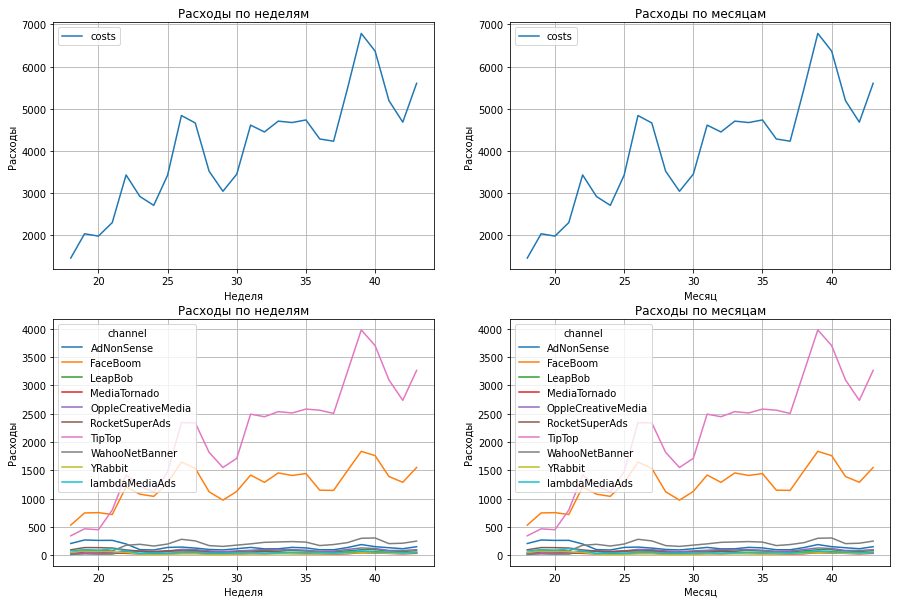

In [22]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
def costs_group(index, dims=[]):
    df=costs.pivot_table(index='week', columns = dims, values='costs', aggfunc='sum')
    return df

costs_week = costs_group('week')
costs_month = costs_group('month')
costs_week_channel = costs_group('week',dims=['channel'])
costs_month_channel = costs_group('month',dims=['channel'])

plt.figure(figsize=(15,10))
ax1=plt.subplot(2,2,1)
costs_week.plot(grid=True, ax=ax1)
plt.ylabel('Расходы')
plt.xlabel('Неделя')
plt.title('Расходы по неделям')

ax2=plt.subplot(2,2,2)
costs_month.plot(grid=True, ax=ax2)
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Расходы по месяцам')

ax3=plt.subplot(2,2,3)
costs_week_channel.plot(grid=True, ax=ax3)
plt.ylabel('Расходы')
plt.xlabel('Неделя')
plt.title('Расходы по неделям')

ax4=plt.subplot(2,2,4)
costs_month_channel.plot(grid=True, ax=ax4)
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Расходы по месяцам')

plt.show()

Из первых двух графиков видно, что расходы на привлечение клиетов постоянно росло. Максимальные расходы в месяц достигали 22000, максимальные расходы в неделю чуть меньще 7000. Причины роста заметны на графиках с разбивкой по каналам: постоянное увеличение затрат на привлечение клиентов с помощью каналов TipTop и FaceBoom.

In [23]:
display(
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .rename(columns={'acquisition_cost':'avg_costs'})
    .sort_values(by='avg_costs',ascending=False)
)

,avg_costs
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


В среднем наибольшая стоимость привлечения пользователя у каналов привлечения: TipTop - 2.8, FaceBoom - 1.11, AdNonSense - 1.01. У остальных каналов привлечения средняя стоимость привлечения клиента находится в диапозоне от 0.21 до 0.72.

## Окупаемость рекламы

In [24]:
observation_date = datetime(2019,11,1).date()
horizon_days=14

### All users. Графики LTV и ROI. Графики динамики LTV, CAC и ROI. 

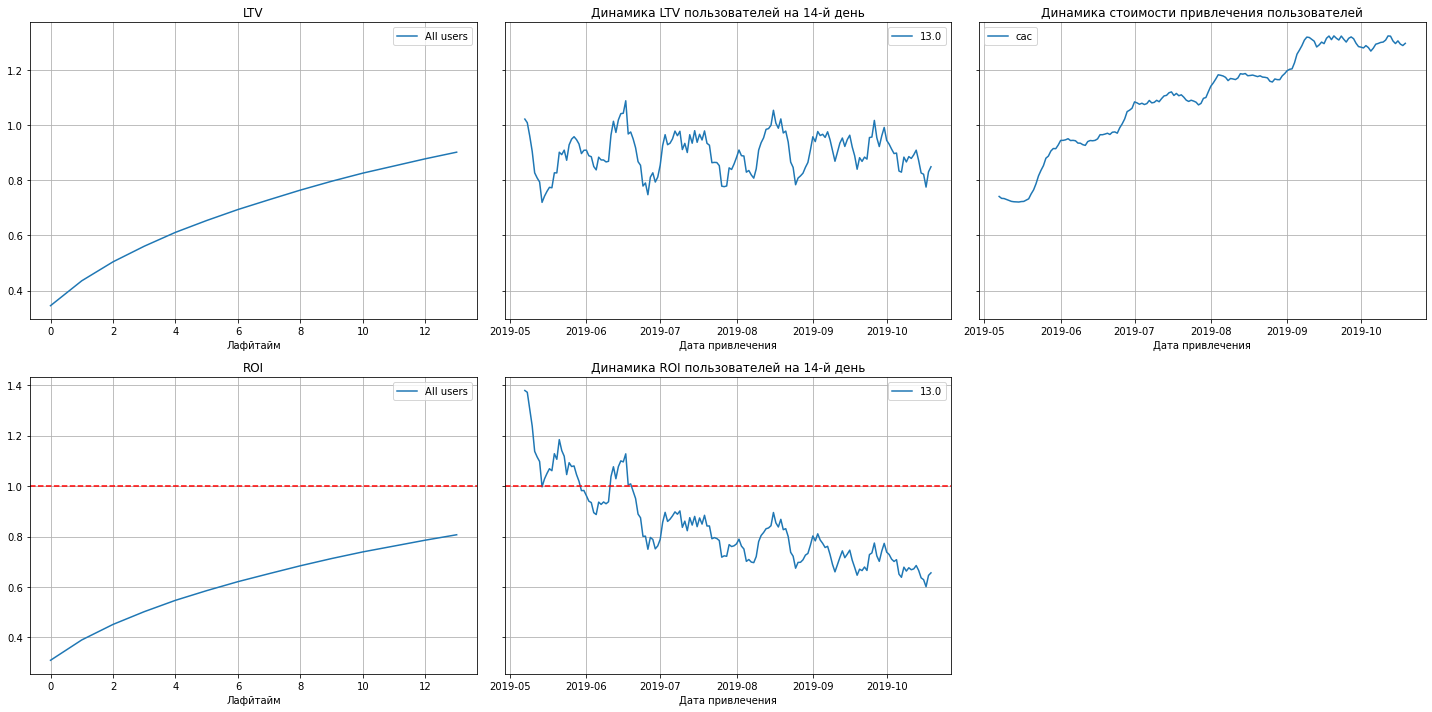

In [25]:
ltv_raw, ltv, roi, ltv_history, roi_history = get_ltv(
    profiles, orders, observation_date,horizon_days,dimensions=[]
)

plot_ltv_roi(ltv,ltv_history, roi, roi_history, 14 )


В первую очередь, следует отметить, что при анализе данных были исключены данные о пользователях, привлеченных органически. Опираясь, на графики можно сделать выводы, что LTV поступательно стремится к 1, но окупаемость даже на 14 день не пересекает уровень окупаемости. Судя по динамики LTV пользователей на 14-й день прибыль варировалась от 0.7 до 1.1 с одного пользователя. Динамика стоимости привлечения менее стабильна: на пользователей, привлеченных в мае, стоимость привлечения одного клиента была около 0.7, к ноября данный показатель практически достиг 1.4. Опирая на данные графика ROI, в течение 2-х недельного лайфтайма, клиенты не окупилсь. Лишь пользователи, привлеченные в мае, и небольшая часть клиентов июня окупились, затем с ростом затрат, линия окупаемости опускалась ниже уровня окупаемости.

### Графики конверсии и удержания

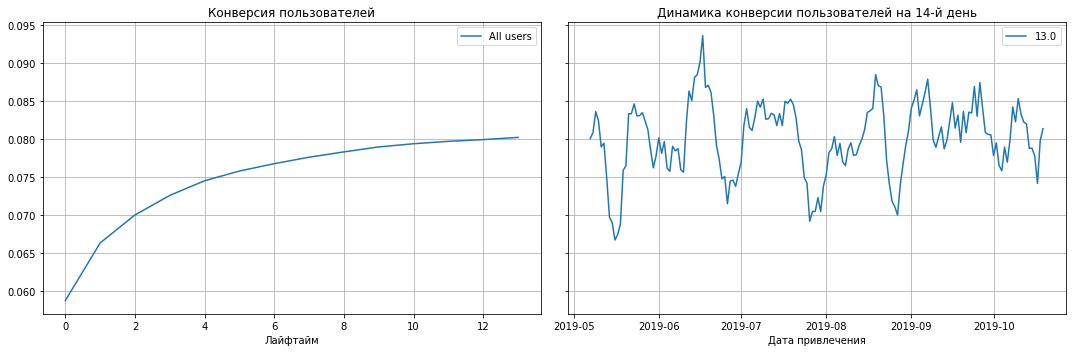

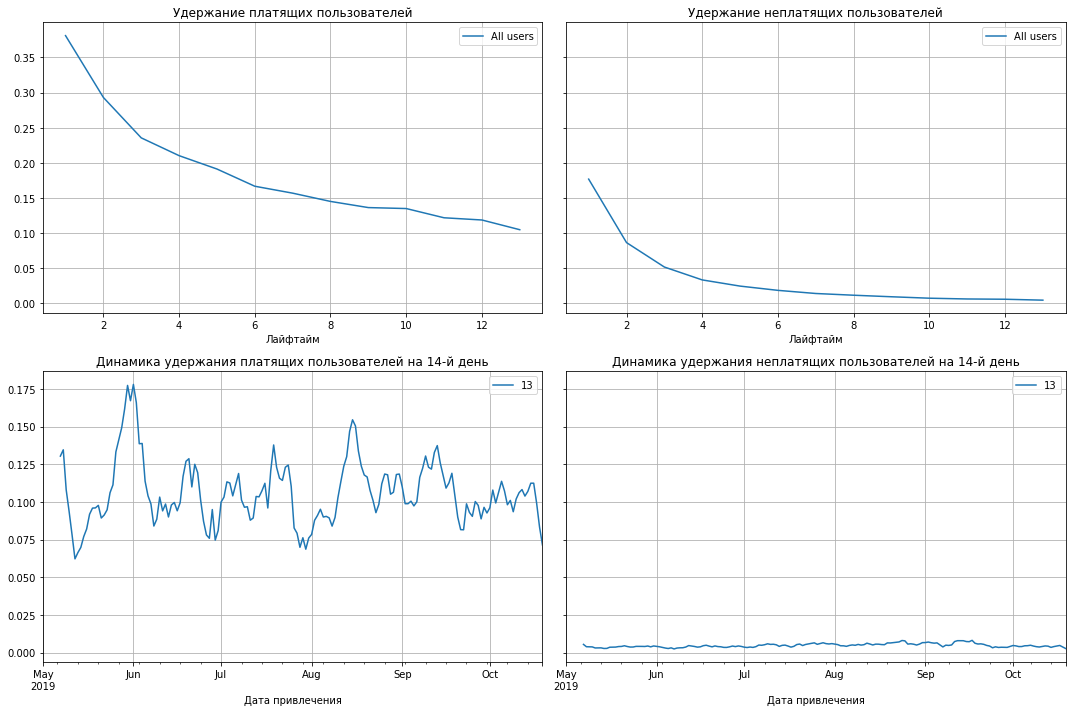

In [26]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=[]
)


plot_conversion (conversion, conversion_history, 14)

retention_raw, retention, retention_history = get_retention(
    profiles, users, observation_date,horizon_days,dimensions=[]
)
plot_retention(retention, retention_history, 14)


Исключив "органических" пользователей, мы наблюдаем медленный рост конверсии; к 14-ому дню чуть больше 8% пользователей становятся покупателями. При этом наименьшие показатели у "майских" пользователей, а, начиная с "июньских", конверсия сильно колеблится около 8%.

Пользователи плохо удерживаются, к концу второй недели остается меньше 15% платящих пользователей и чуть больше 0% - неплатящих. При этом, судя по динамике удержание у платящих показатели колеблится от 7,5% до 17,5%, у неплатящих - чуть больше 0.

### Окупаемость пользователей с разбивкой по устройствам.

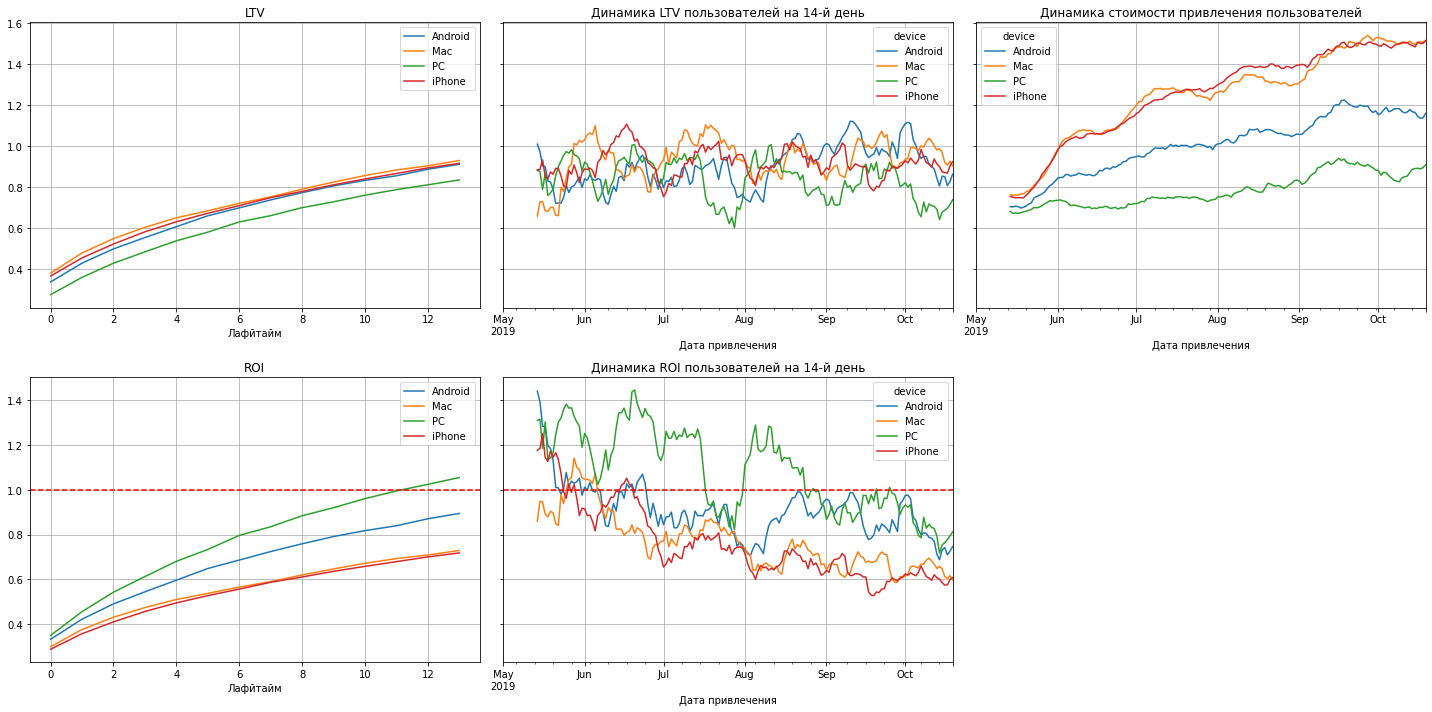

In [27]:
ltv_raw, ltv, roi, ltv_history, roi_history = get_ltv(
    profiles, orders, observation_date,horizon_days,dimensions=['device']
)

plot_ltv_roi(ltv,ltv_history, roi, roi_history, 14, 14)

Сгруппировав пользователей по устройству, видем, что LTV по всем устройствам стабильно растет и к 12 дню лайфтайма превышает 0.8. Из особенности можно отметить небольшое отставание в прибыли у пользователей PC, но это не мешает окупаться им на 11-й день. Пользователи остальных устройств не окупаются к концу второй недели. Если обратиться к графику динамики LTV, то пользовател каждой когорты ведут себя более менее одинаково. Но на графике динамики ROI отчетливо видно, что кривая пользователей PC практически до конца августа не опускаются ниже уровня окупаемости, за исключением неокупившихся пользователей привлеченных во второй половине июля. Часть пользователей Android, привлеченных в мае окупаются, но из-за роста затрат на привлечение глоабально пользователи не окупаются к 14-ому дню лайфтайма. Пользователи системы Ios схожи: рост прибыли и затрат растут одинаково, пользователи не окупаются, небольшая группа пользователей привлеченных в мае окупается, но в остальном ситуация не утешительная.

Очевидно, что пользователи PC окупились, потому что уровень затрат не превысил 1.0.

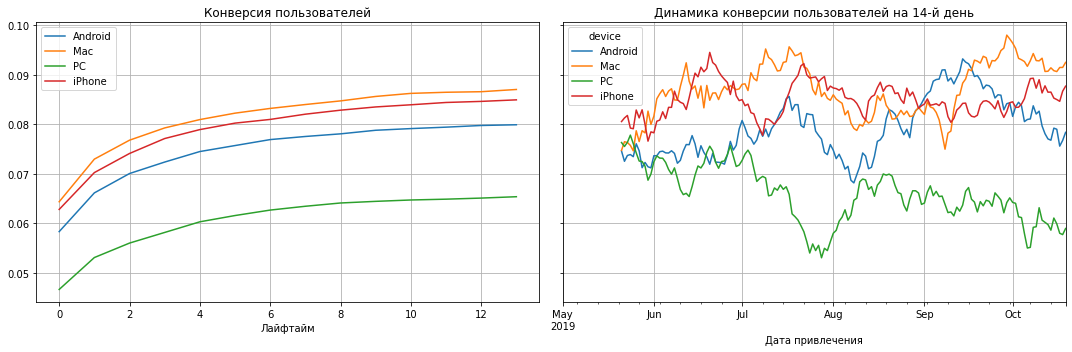

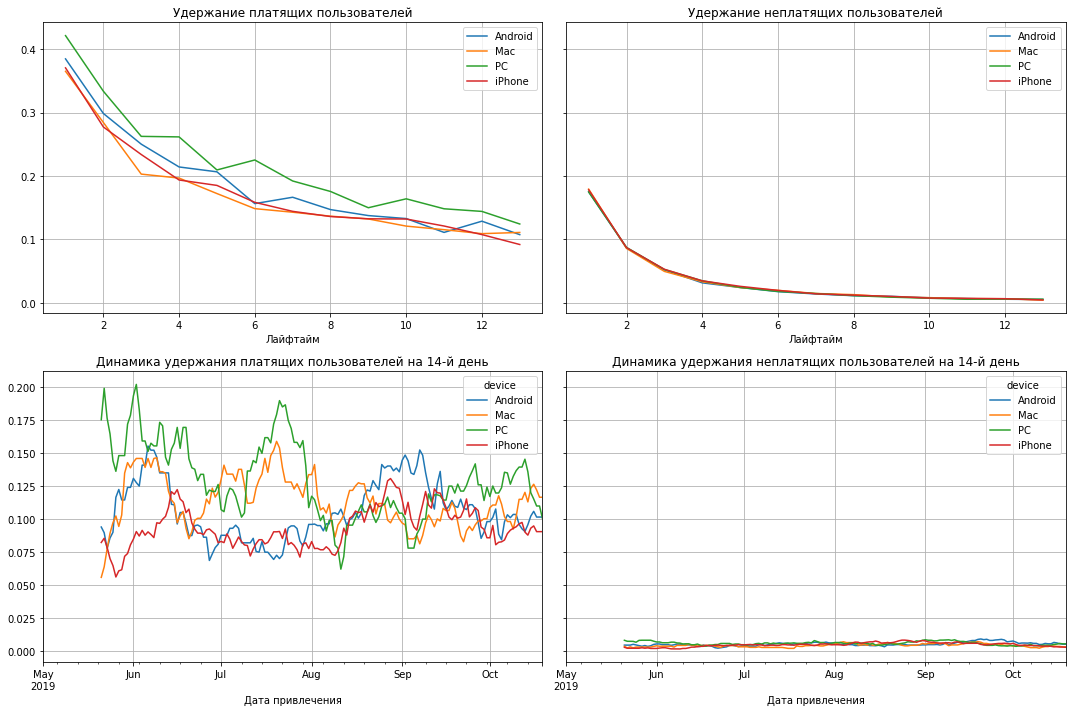

In [28]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['device']
)
plot_conversion (conversion, conversion_history, 14, 21)

retention_raw, retention, retention_history = get_retention(
    profiles, users, observation_date,horizon_days,dimensions=['device']
)
plot_retention(retention, retention_history, 14, 21)

Построив графики конверсии и удержания, следует отметить сильное отставание в конверсии у пользователей, использующих PC.

### Окупаемость пользователей с разбивкой по странам.

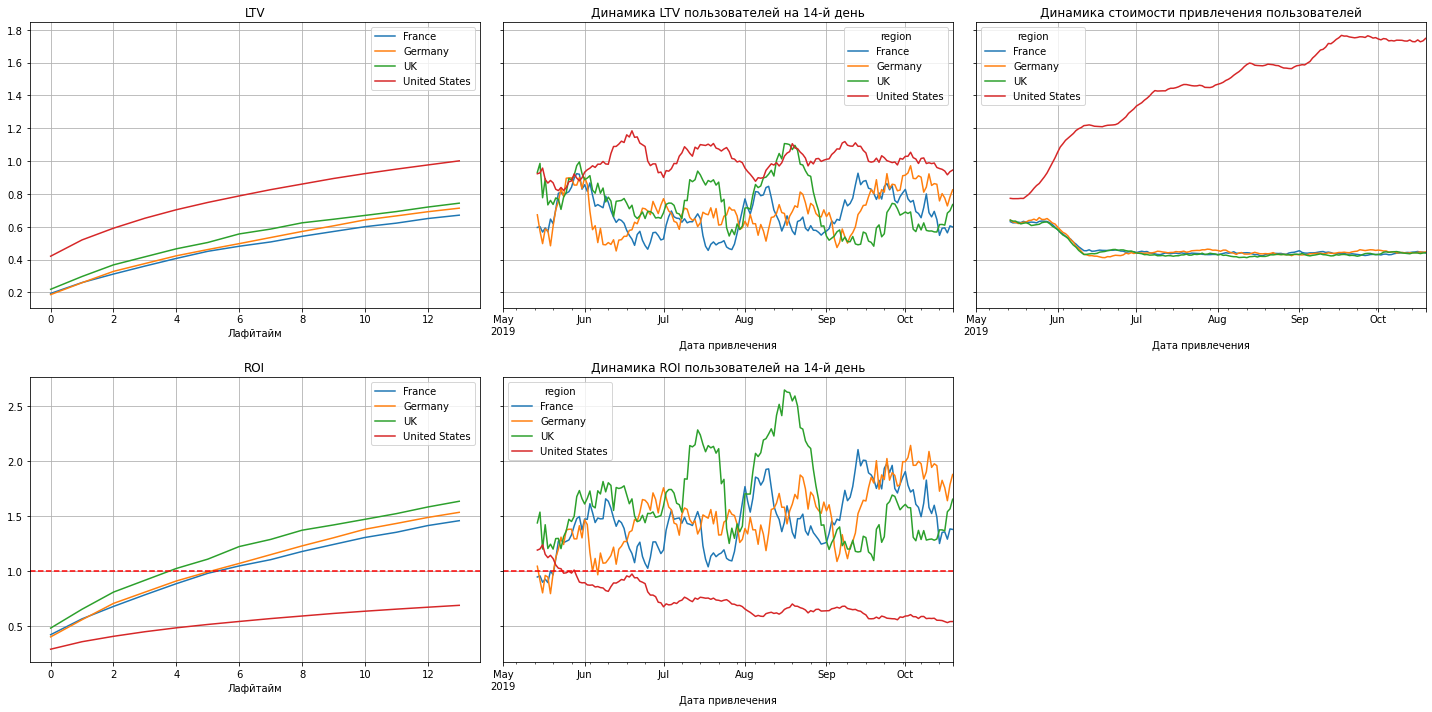

In [29]:
ltv_raw, ltv, roi, ltv_history, roi_history = get_ltv(
    profiles, orders, observation_date,horizon_days,dimensions=['region']
)

plot_ltv_roi(ltv,ltv_history, roi, roi_history, 14, 14)

После построения графиков, заметна схожее поведение у пользователей из трех стран: Германия, Франция и Великобритания. Прибыль в среднем на 14-й день достигает 0.6-0.8, на протяжении всех дат привлечения прибыль с пользователя варируется от 0.4 до 1.0. Расходы в мая находятся на уровне 0.6, начиная с середины июня опускаются до 0.4, поэтому пользователи окупаются между 4 и 6 днями лайфтайма. 

Совершенно другие показатели у пользователей из Соендиненных Штатов. Пользователи на протяжении всего лайфтайма обгоняют пользователей из других стран на 0.2, а к 14 дню преодолевает отметку 1.0. Начиная с "июньской" когорты прибыль на 14 день находится около 1.0. Однако пользователи из Америки не окупаются на протяжении всего лайфтайма, лишь небольшая группа пользователей привлеченных в мае и июне на 14-й день окупается. Причина снова кроется в завышенных затратах. С мая по июнь затраты не превышали 1.1, но к концу периода затраты практически достигли 1.8 на одного клиента.

Рекомендации те же: не превышать затраты на привлечение пользователей из USA 1.0 на пользователя.

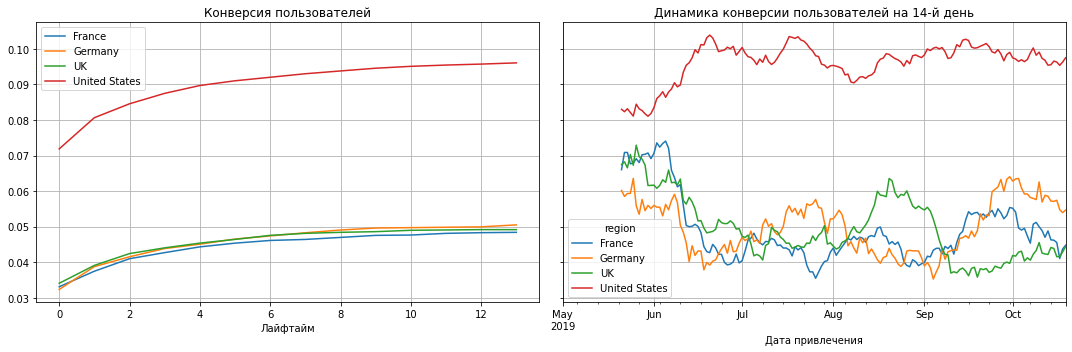

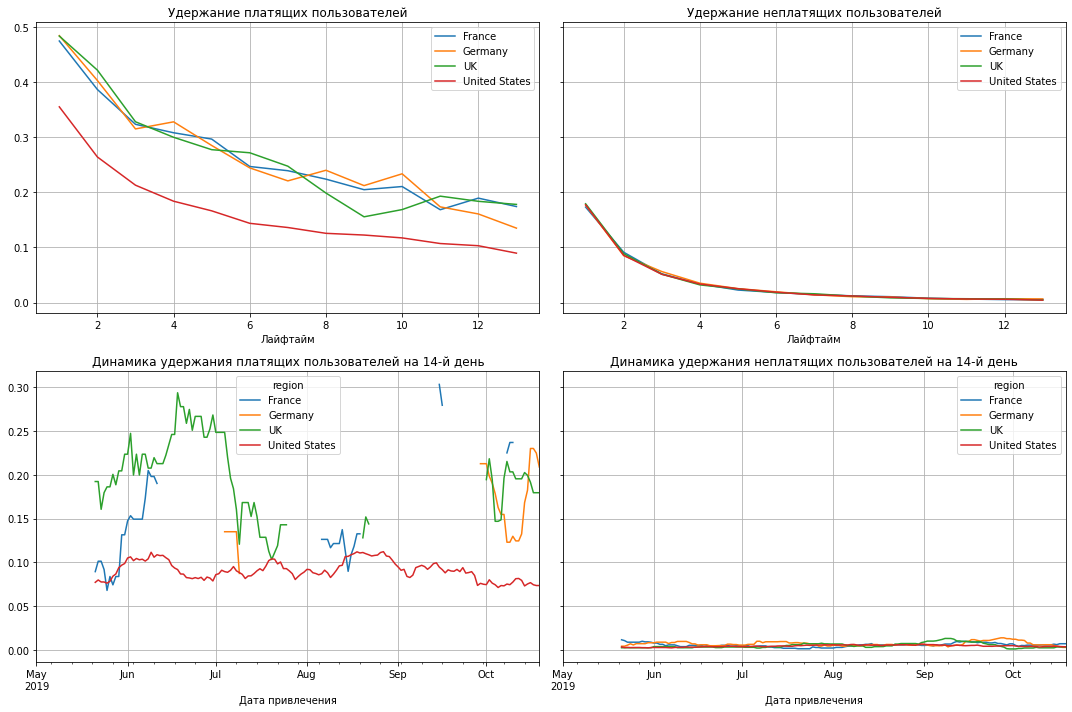

In [30]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['region']
)
plot_conversion (conversion, conversion_history, 14, 21)

retention_raw, retention, retention_history = get_retention(
    profiles, users, observation_date,horizon_days,dimensions=['region']
)
plot_retention(retention, retention_history, 14, 21)

Конверсия у пользователей из USA наибольшая, но удержание платящих из этого региона находится на самом низком уровне относительно остальных регионов. О чем это говорит, мне сложно сказать.

Также следует отметить,что динамика удержания платящих пользователей на 14-й день выглядит "рвано".

### Окупаемость пользователей с разбивкой по рекламным каналам.

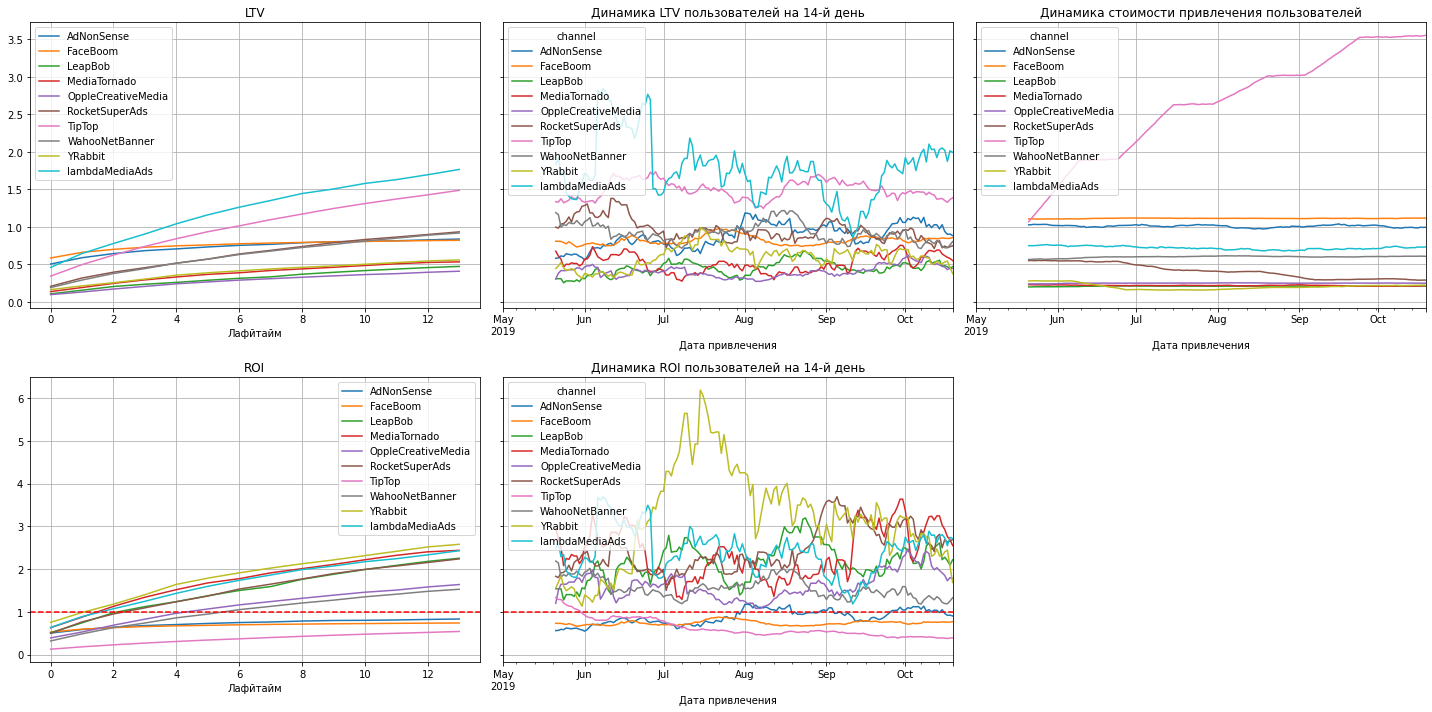

In [31]:
ltv_raw, ltv, roi, ltv_history, roi_history = get_ltv(
    profiles, orders, observation_date,horizon_days,dimensions=['channel']
)

plot_ltv_roi(ltv,ltv_history, roi, roi_history, 14, 21)

Исходя из графиков, можно сделать вывод, что затраты на канал привлечения (далее - канал) TipTop кратно завышены, поэтому он не окупается. Для начала необходимо снизить затраты до 1.0 и посмотреть на окупаемость, так как прибыль на 14_й день по данному каналу находится около 1.5 с пользователя, скорее всего мы выйдем в плюс. Канал находится на втором месте по приносимой прибыли.

Помимо TipTop есть еще два неокупаемых канала: FaceBoom и AdNonSense. Они находятся ближе к уровню окупаемости, но все равно не пересекают его. Средняя прибыль с человека, привлеченных с этих каналов не превышает 1.0. И если от канала AdNonSense можно отказаться из-за небольшого числа привлеченных пользователей (3702 чел.), то от FaceBoom отказываться нельзя - количество привлеченных пользователей 27,5 тысяч. На динамике LTV  видно, что прибыль на 14 день чуть больше 0.5, значит затраты не должны превышать данного числа. Для определения истинных причин неокупаемости, ниже построим графики удержания и конверсияя с разбивкой по каналам.

Остальные каналы окупаются со 2 по 5 день лайфтайм, соотвественнно по ним можно увеличивать затраты на привлечение клиентов. Особое внимание заслуживает канал lambdaMediaAds , который является лидером по показателю LTV, и канал YRabbit, окупаемость которого на 14 день достигает 600% процентов. Очевидно, в первую очередь нужно вкладываться в рекламу на данных каналах.

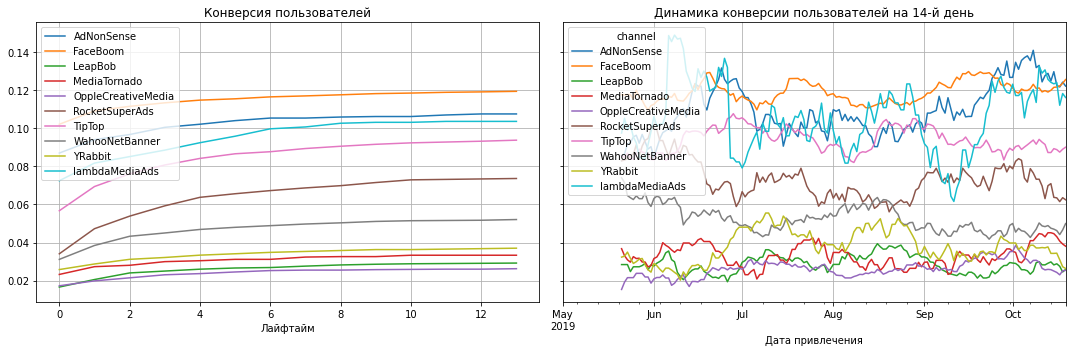

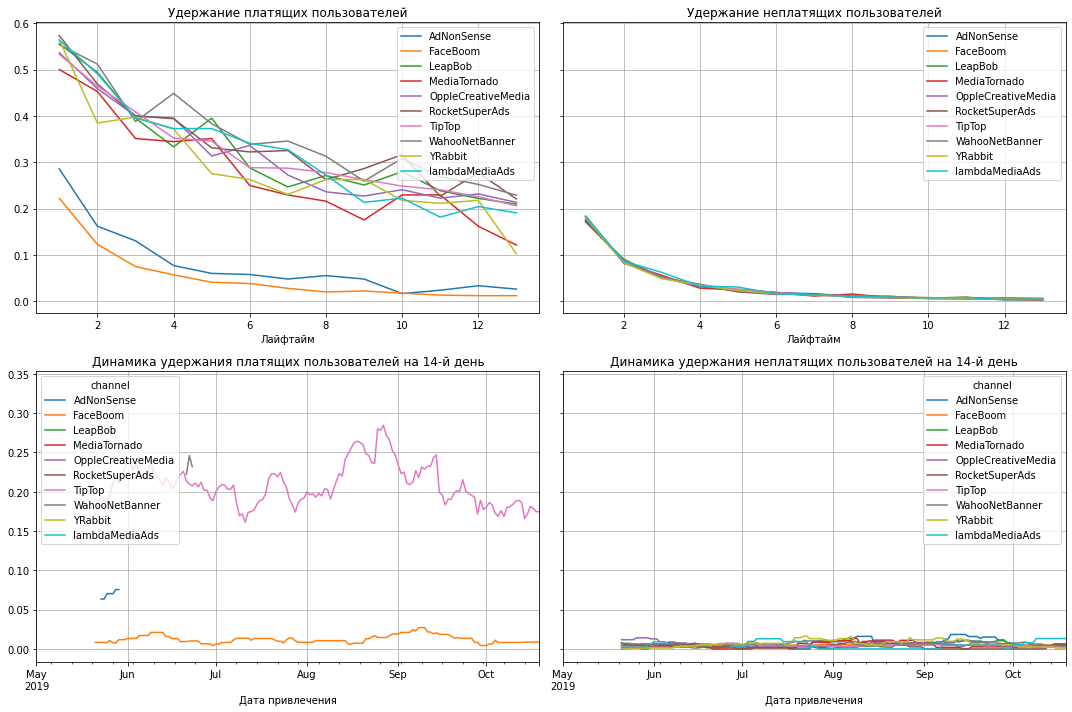

In [32]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days,dimensions=['channel']
)
plot_conversion (conversion, conversion_history, 14, 21)

retention_raw, retention, retention_history = get_retention(
    profiles, users, observation_date,horizon_days,dimensions=['channel']
)
plot_retention(retention, retention_history, 14, 21)

Конверсия и динамика конверсия у всех источников разная, но на обоих графиках виден лидер - FaceBoom. Практически 12% пользователей становятся покупателями, при этом удержание к 14-ому дню практически достигает нуля, вне зависимости от даты привлечения клиента. Следует запросить данные об событиях или обращениях клиентов, возможно мы столкнулись с какой-то технической проблемой.

Схожая ситуация у канала привлечения AdNonSense, с единственным отличием: до 14 дня лайфтайма добралась лишь часть "майских" клиентов. 

Наилучшие показатели удержания клиентов на 14-ый день у канала привлечения TipTop, при этом по уровню конверсии этот канал находится на 4 месте.

Стоит отметить, что динамика конверсии у платящих клиентов на 14-й день по остальным каналам не отображена на графике, из чего можно сделать, что они не "доживают" до этого дня. Что наталкивает нас на мысли об эффективности использования данных каналов.

## Выводы

Целью данного проекта было определить причину неэффективности привлечения пользователей развлекательного приложения Procrastinate Pro+ и предложить рекомендации для отдела маркетинга. В ходе работы были изучены и обработаны данные из полученных от компании данных о посещениях, покупках пользователей и затрат на них. 

После исследовательского анализа данных выявлено, что в период с 01 мая 2019г. по 27 октября 2019г. наибольшая конверсия в покупатель из Соединенных Штатов Америки, пользователей использующих Mac, а также пользователей, перешедших с канала привлечения FaceBoom. 

На этапе «Маркетинг» была выявлена тенденция в увеличении трат на рекламу, итог затрат на рекламу составил более 105 тыс. При этом наибольшие вложения в привлечение пользователей были направлены на канал TipTop (общие затраты – 54 751), где средние затраты на одного пользователя составили около 2.8 у.е.

При оценке окупаемости было выявлено, что пользователи не окупаются и причиной являются завышенные затраты на привлечение клиентов. У приложения Procrastinate Pro+ хорошая конверсия, но удержание платящих клиентов к 14 дню стремится к 10%. При разбивке пользователей по устройствам, из-за больших затрат на привлечение пользователей Mac и iPhone, пользователи данных устройств не окупаются. Схожие причине не окупаемости у пользователей из USA – завышенные затраты на привлечение. После разбивки по каналам привлечения, мы выявили 3 канала с завышенными затратами на рекламу (TipTop, FaceBoom и AdNonSense), а также выявлены наиболее эффективные каналы: lambdaMediaAds и YRabbit.

Причинами неэффективности привлечения пользователей является завышенные траты на привлечение клиентов по ряду каналов и игнорирование наиболее прибыльных каналов.
Рекомендации:
1.	Снизить затраты на каналы TipTop, FaceBoom и AdNonSense ниже усредненного прибыли по данным каналам.
2.	Направить финансовые средства для усиления привлечения пользователей по остальным каналам, особенно по каналу lambdaMediaAds, который является лидером по показателю LTV, и канал YRabbit, окупаемость которого на 14 день достигает 600% процентов.
3.	Контролировать затраты на пользователей Mac и iPhone, а также покупателей из USA на уровне средних затрат на клиента 0.5 у.е.
